In [27]:
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import glob
import warnings
warnings.filterwarnings(action='ignore')

In [82]:
def get_stokes_i(fitsname):
    hdu = fits.open(fitsname)
    data = hdu[0].data 
    if data.ndim == 4:
        data = data[0,0,:,:]
    elif data.ndim == 5:
        data = data[0,0,0,:,:]
    
    if data.ndim != 2:
        raise Exception('not recognized')
        
    if data.shape == (640, 640):
        data = data[64:-64, 64:-64]
    
    return data
        

# plot a whole list of fits data files
# fits_names: if 2D list, makes plots along the second dimension, with corresponding
#             entries along the first dimension passed as a list to the combine function
def plot_all(fits_names, rows=1, combine=lambda d : d[0], lim=None, titles=None, 
             display_statistic=np.std, grid=True, hide_axis_label=True):
    
    if fits_names == [[]] or fits_names == []:
        raise Exception('empty list given')
    
    # turns fits_names into a 2D-list
    if not isinstance(fits_names, list):
        fits_names = [fits_names]
    if not isinstance(fits_names[0], list):
        fits_names = [fits_names]
    
    if lim == None or len(lim) < 2:
        lim = [None,None]
    
    if titles == None:
        titles = fits_names[0]
    
    cols = int(np.ceil(len(fits_names[0]) / rows))
    
    wcs = WCS(fits.open(fits_names[0][0])[0].header, naxis=2)
            
    fig, axes = plt.subplots(figsize=(24,24),nrows=rows, ncols=cols, sharex=True, sharey=True, 
                             subplot_kw={"projection":wcs, "title":""})
    plt.rcParams.update({'font.size': 18})

    #make axes 2D
    if rows == 1:
        axes = [axes]
    if cols == 1:
        axes = [[x] for x in axes]

    for i in range(rows):
        for j in range(cols):  
            
            x = cols * i + j
            if x >= len(titles):
                break
            
            #grabs image data from all fits files in xth position, passes to combine
            images = [get_stokes_i(fits_list[x]) for fits_list in fits_names]
            data = combine(images)
            displ = '{:.3g}'.format(display_statistic(data))
                        
            im = axes[i][j].imshow(data, label=displ, vmin=lim[0], vmax=lim[1])
            if grid:
                axes[i][j].grid()
            axes[i][j].set_title(titles[x])
            
            if len(titles) - x <= cols or not hide_axis_label:
                axes[i][j].set_xlabel('RA')
            else:
                axes[i][j].set_xlabel(' ')
            if j == 0 or not hide_axis_label:
                axes[i][j].set_ylabel('DEC')
            else:
                axes[i][j].set_ylabel(' ')
            
            fig.colorbar(im,ax=axes[i][j],use_gridspec=True,fraction=0.046,pad=0.04)
            axes[i][j].text(400, 470, displ, bbox={'facecolor': 'white', 'pad': 10})
            
    plt.tight_layout(pad=3.5)
    #return fig, axes

In [89]:
#path = "/lustre/aoc/projects/hera/aseidel/mask_and_none_simulated/"
#path = "/lustre/aoc/projects/hera/aseidel/tclean_paramaters/32476/"
#path = "/lustre/aoc/projects/hera/aseidel/tclean_paramaters/74025/"
path = "/lustre/aoc/projects/hera/aseidel/time_intervals_test/*/split_*_24_deconvolved"

no_deconvolution = glob.glob(path+"no_deconvolution.image.fits")
psf = glob.glob(path+"*psf.fits")

print(psf)
plot_all(fits_names=[no_deconvolution,psf], titles=['no_deconvolution', 'psf'],
        combine = lambda d : (d[0] / np.max(d[0])) - (d[1] / np.max(d[1]))) 


['/lustre/aoc/projects/hera/aseidel/time_intervals_test/0.50_min/split_24_of_24_deconvolved.psf.fits', '/lustre/aoc/projects/hera/aseidel/time_intervals_test/0.50_min/split_4_of_24_deconvolved.psf.fits', '/lustre/aoc/projects/hera/aseidel/time_intervals_test/0.50_min/split_10_of_24_deconvolved.psf.fits', '/lustre/aoc/projects/hera/aseidel/time_intervals_test/0.50_min/split_21_of_24_deconvolved.psf.fits', '/lustre/aoc/projects/hera/aseidel/time_intervals_test/0.50_min/split_6_of_24_deconvolved.psf.fits', '/lustre/aoc/projects/hera/aseidel/time_intervals_test/0.50_min/split_17_of_24_deconvolved.psf.fits', '/lustre/aoc/projects/hera/aseidel/time_intervals_test/0.50_min/split_1_of_24_deconvolved.psf.fits', '/lustre/aoc/projects/hera/aseidel/time_intervals_test/0.50_min/split_23_of_24_deconvolved.psf.fits', '/lustre/aoc/projects/hera/aseidel/time_intervals_test/0.50_min/split_16_of_24_deconvolved.psf.fits', '/lustre/aoc/projects/hera/aseidel/time_intervals_test/0.50_min/split_2_of_24_deconv

IndexError: list index out of range

In [90]:
#function to turn a filepath into a key for sorting
#srt_str = lambda s : s.split('_')[-5] + s.split('_')[-2] + s

def srt_str(s) :
#     first = ['r_2', 'r_1', 'r_0.75', 'planes_1_facets_1', 'r_0.25', 'r_0', 'r_-', '0_4_8.', '0_8_32', '_0_', '_4_']
#     last = ['facets_3', 'facets_5', '640x640', '768x768', 'no_deconvolution']
    
#     for i, substr in enumerate(first + ["PlaceHolder"] + last):
#         if substr in s:
#             return chr(i) + s
    
#     return chr(len(first)) + s
    return s
    
    

#path += "*final"
residual = sorted(glob.glob(path + "*.residual.fits"), key=srt_str)
model = sorted(glob.glob(path + "*.model.fits"), key=srt_str)
image = sorted(glob.glob(path + "*.image.fits"), key=srt_str)
psf = sorted(glob.glob(path + "*.psf.fits"), key=srt_str)
#titles = [x.split('/')[-1][:-20] for x in residual]

[residual, model, image, psf] = [x for x in [residual, model, image, psf]]

titles = [x.split('/')[-1][:(-1 * len(".image.fits"))] for x in image]

In [91]:
muellerbeam = get_stokes_i("muellerbeam.fits")

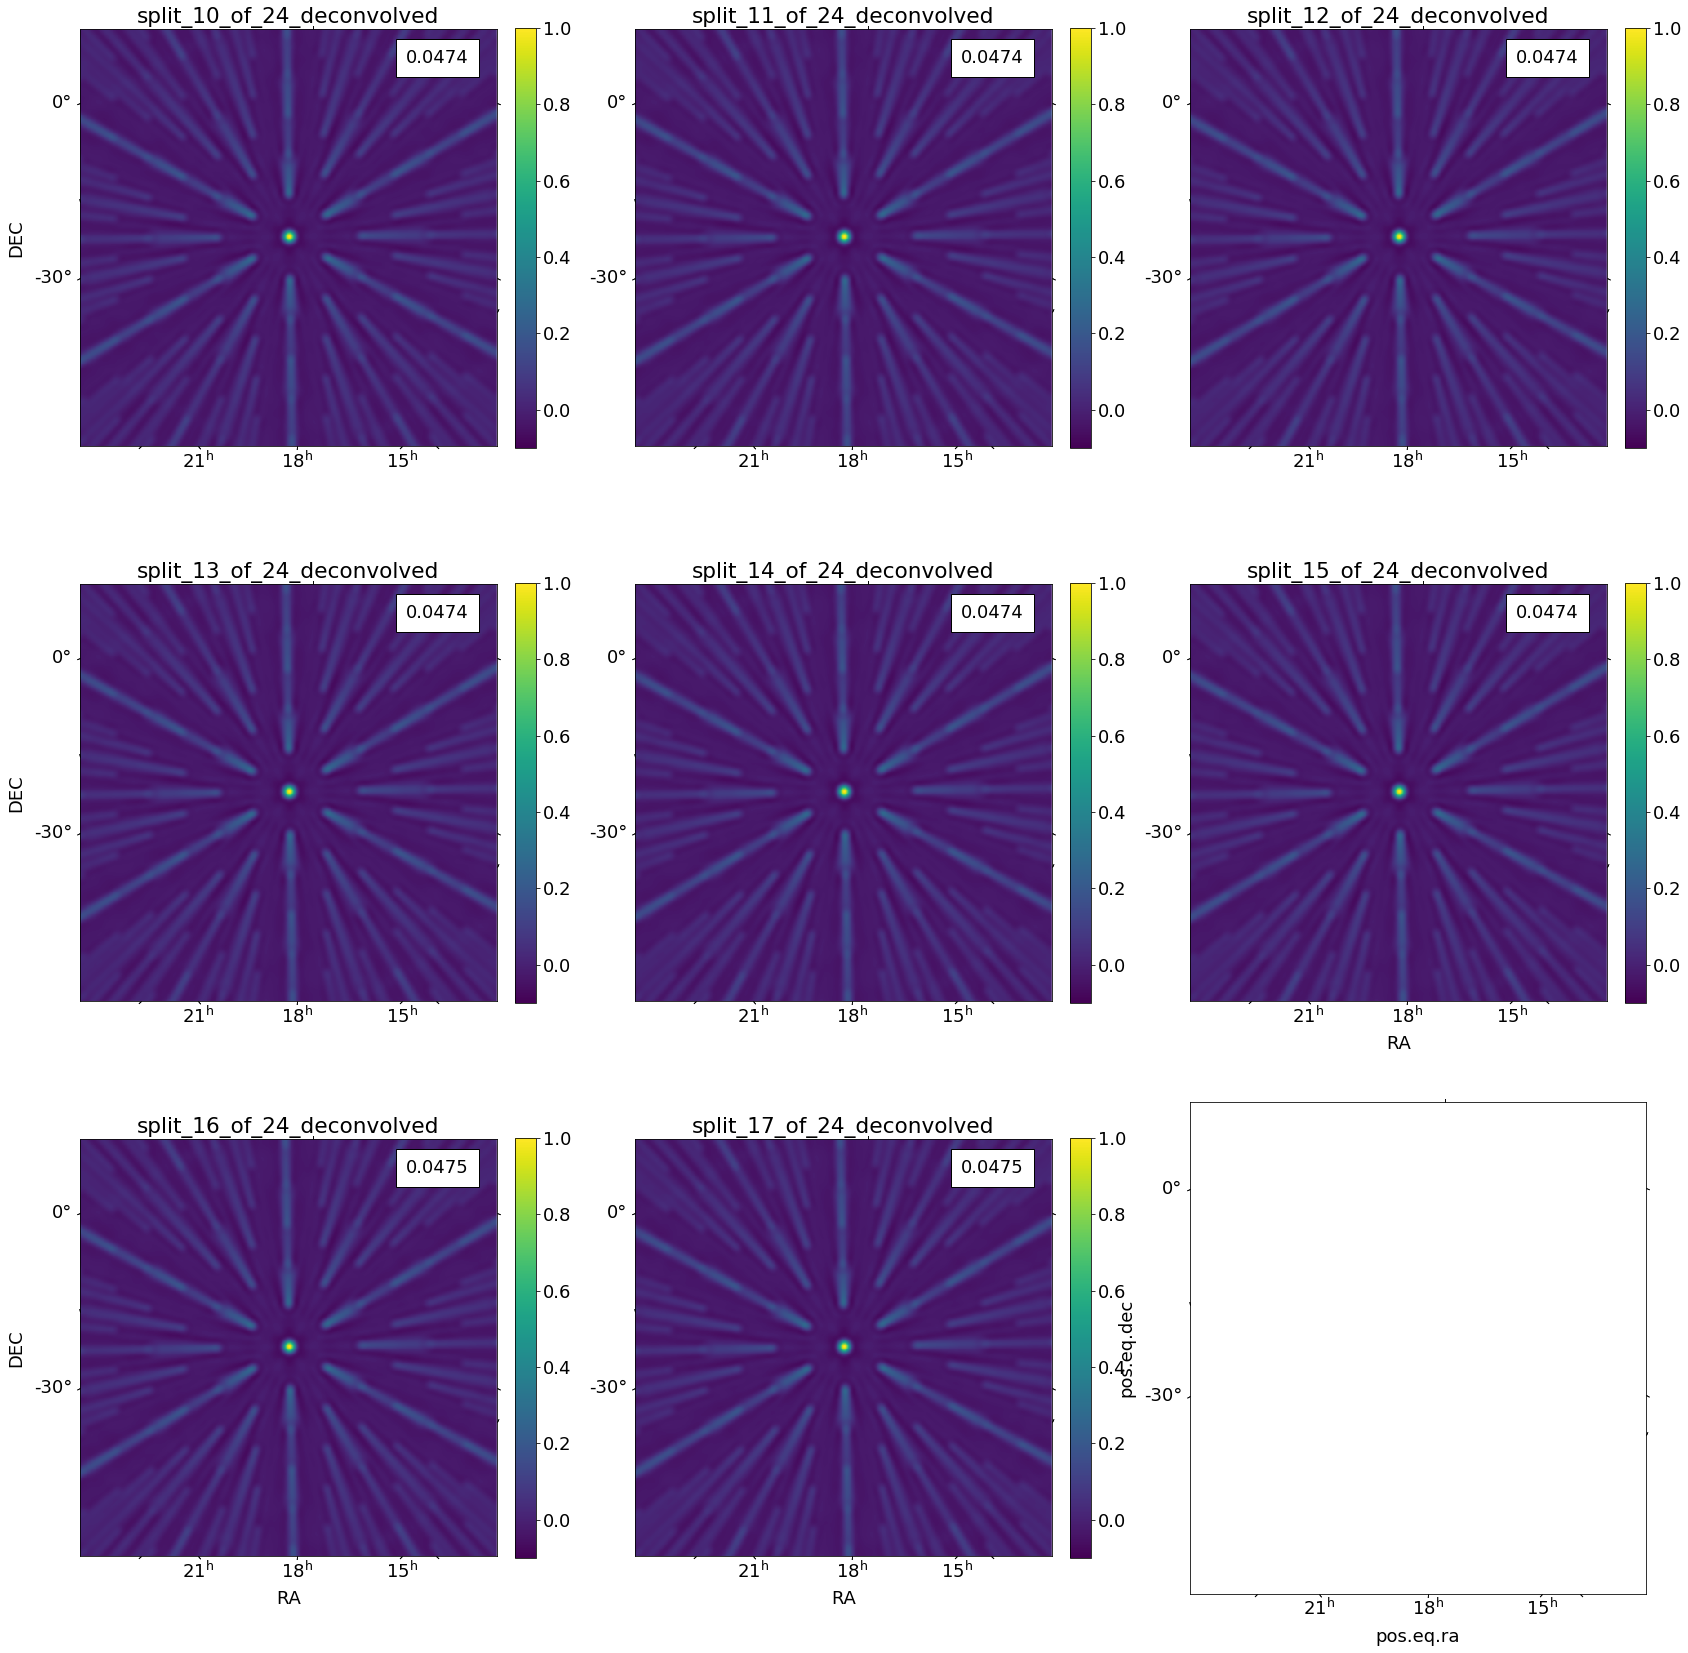

In [92]:
plot_all(fits_names=[psf[:8]], rows=3, titles=titles[:8], lim=[-0.1,1], grid=False)

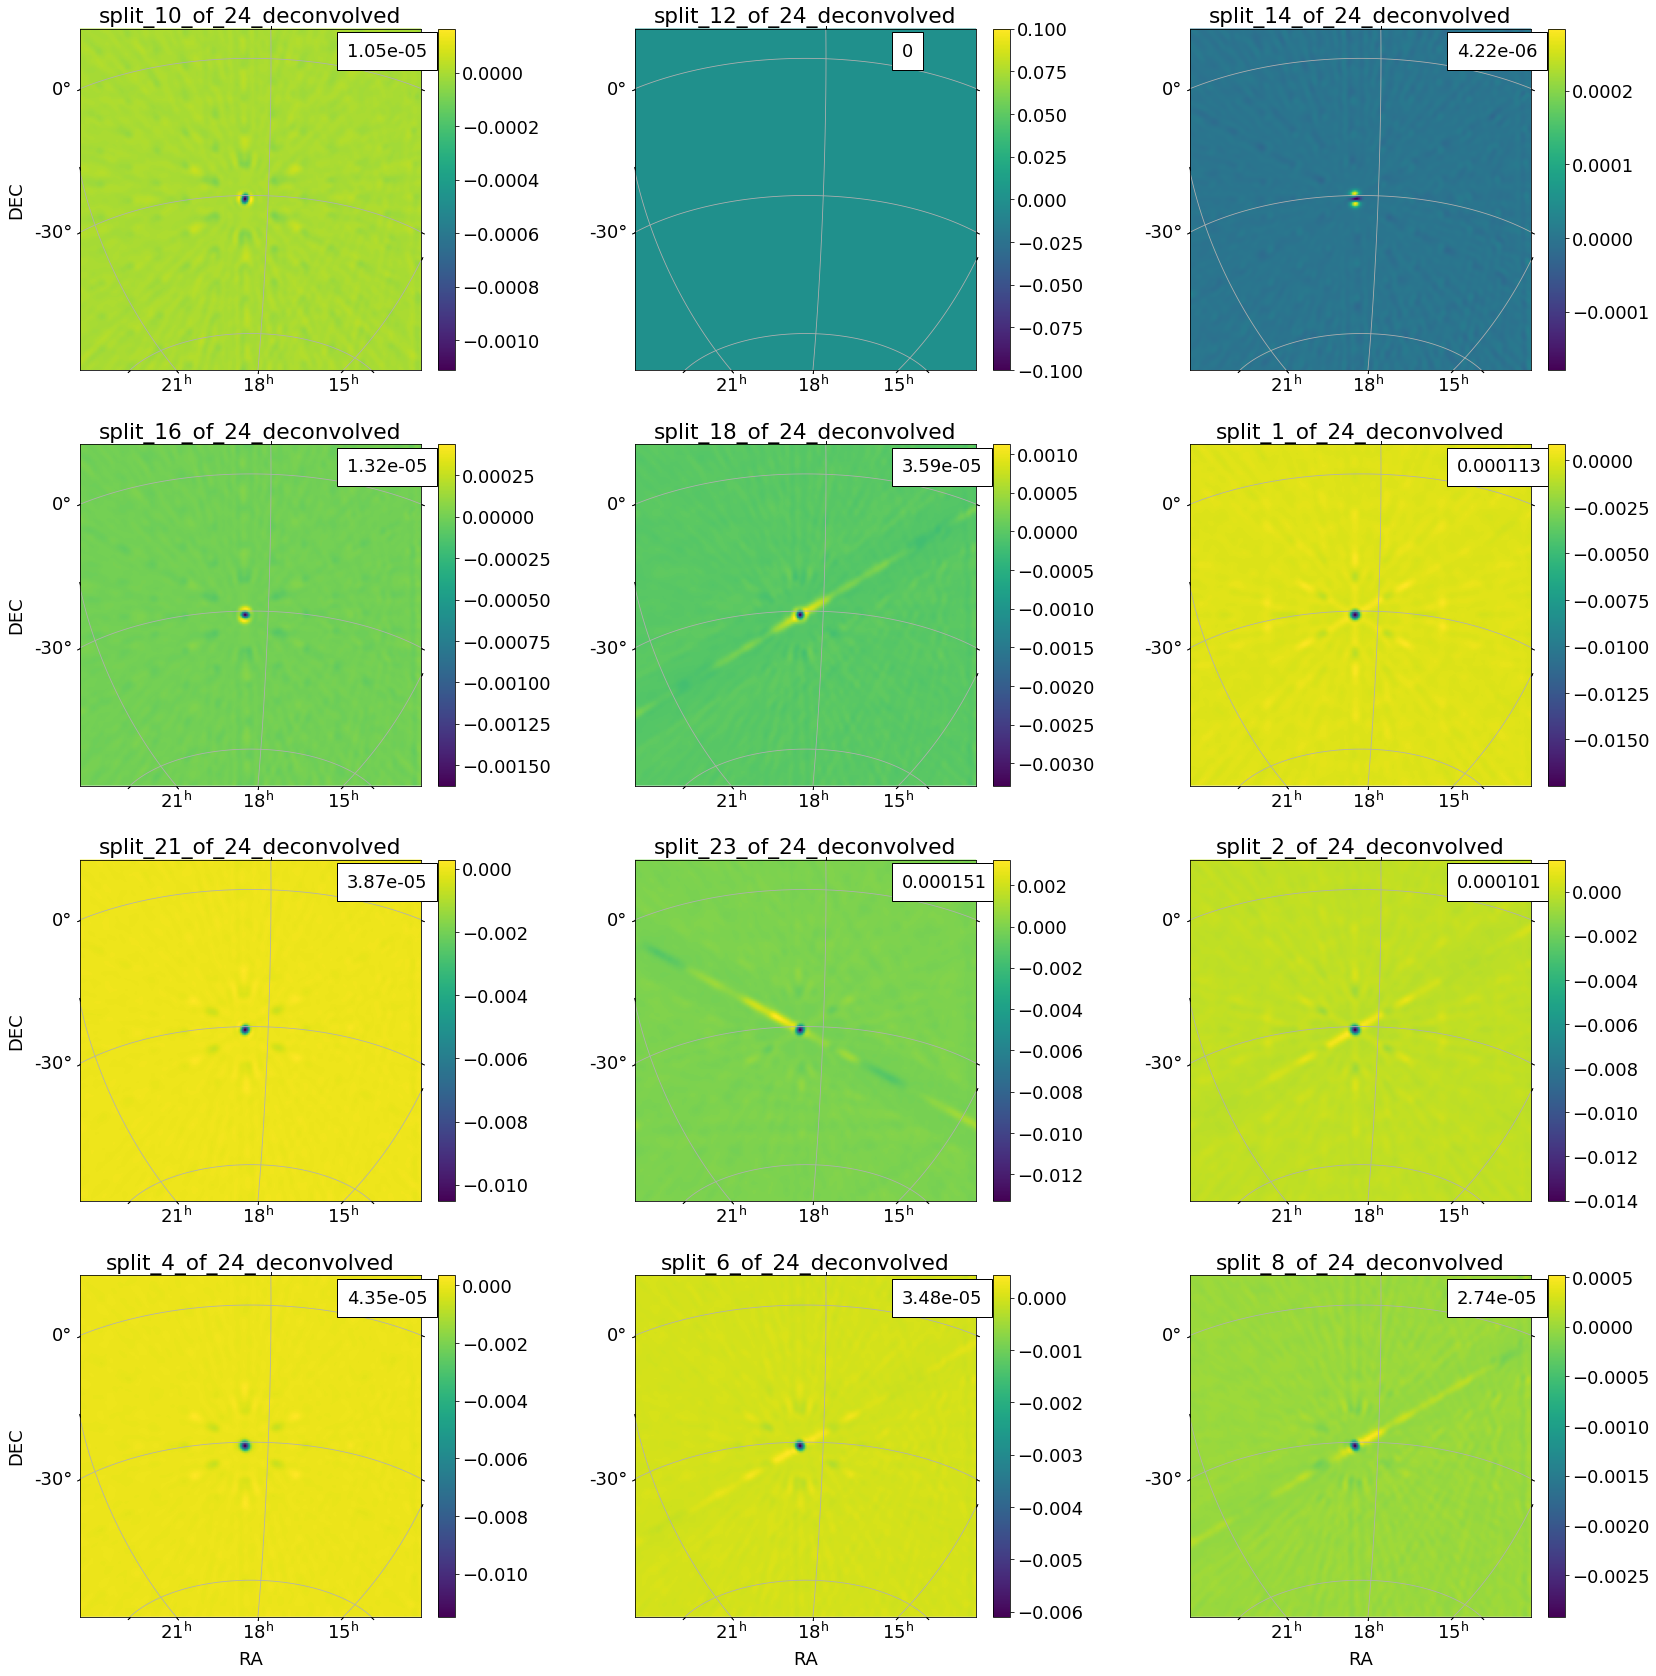

In [95]:
def weighted_std(data):
    weight = muellerbeam < 0.2 * np.max(muellerbeam)
    weighted_mean = np.average(data, weights=weight)
    return (np.sum((weight * (data - weighted_mean)**2)) / np.sum(weight))**0.5

plot_all(fits_names=[image[::2]], rows=4, titles=titles[::2], display_statistic=weighted_std,
        combine = lambda d : d[0] - get_stokes_i('/lustre/aoc/projects/hera/aseidel/time_intervals_test/0.50_min/split_12_of_24_deconvolved.image.fits'))

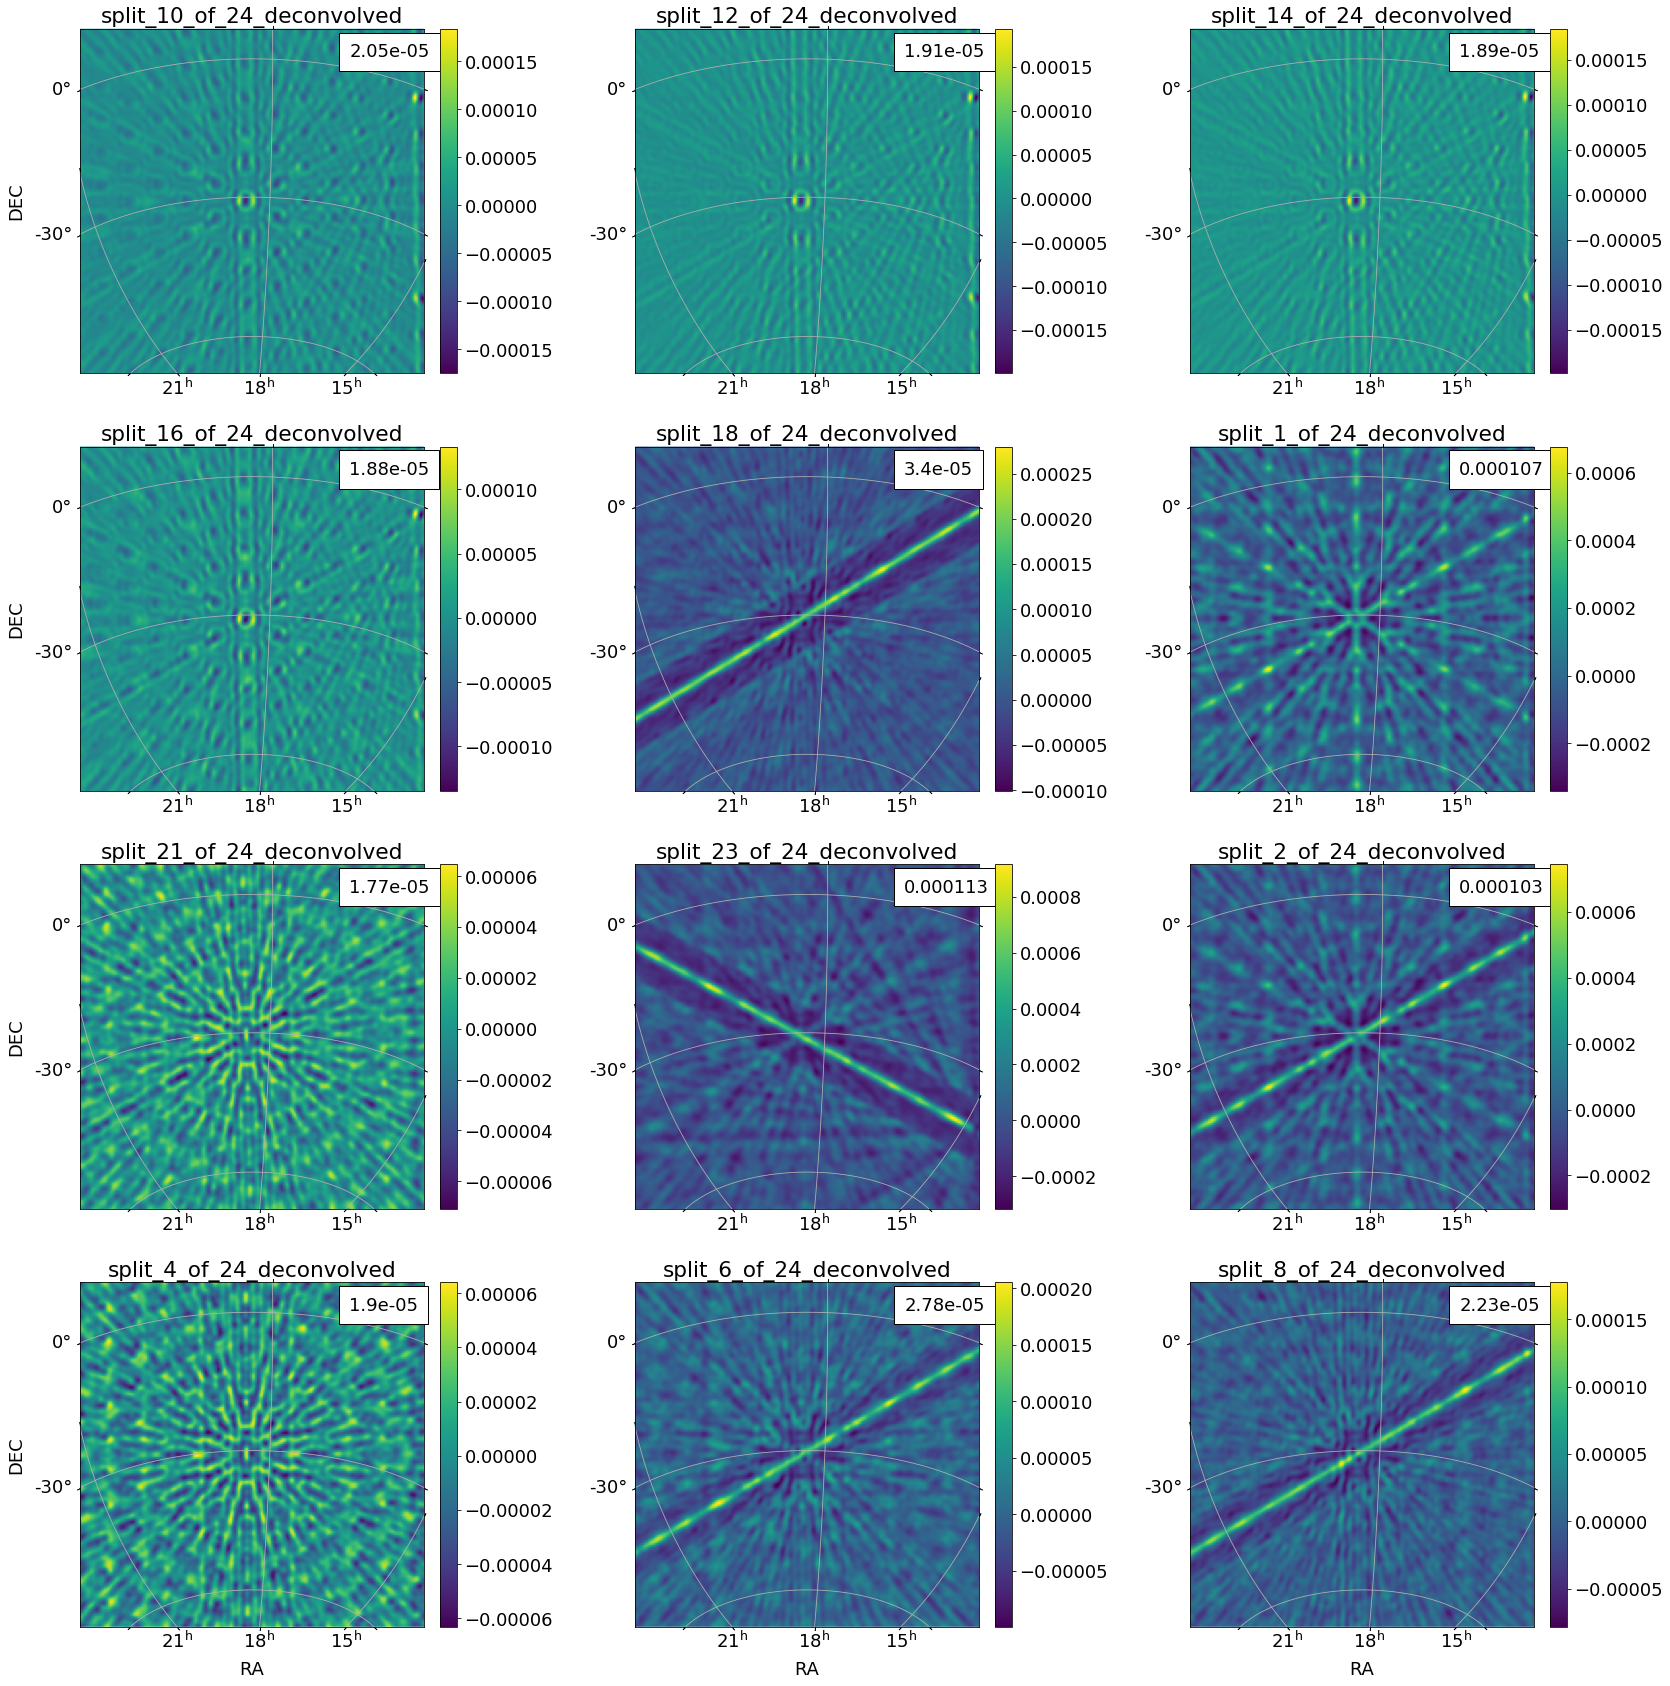

In [97]:
plot_all(fits_names=[residual[::2]], rows=4, titles=titles[::2], display_statistic=weighted_std)
        #combine = lambda d : d[0] - get_stokes_i(path + 'r_-1.00_planes_1.image.fits'))

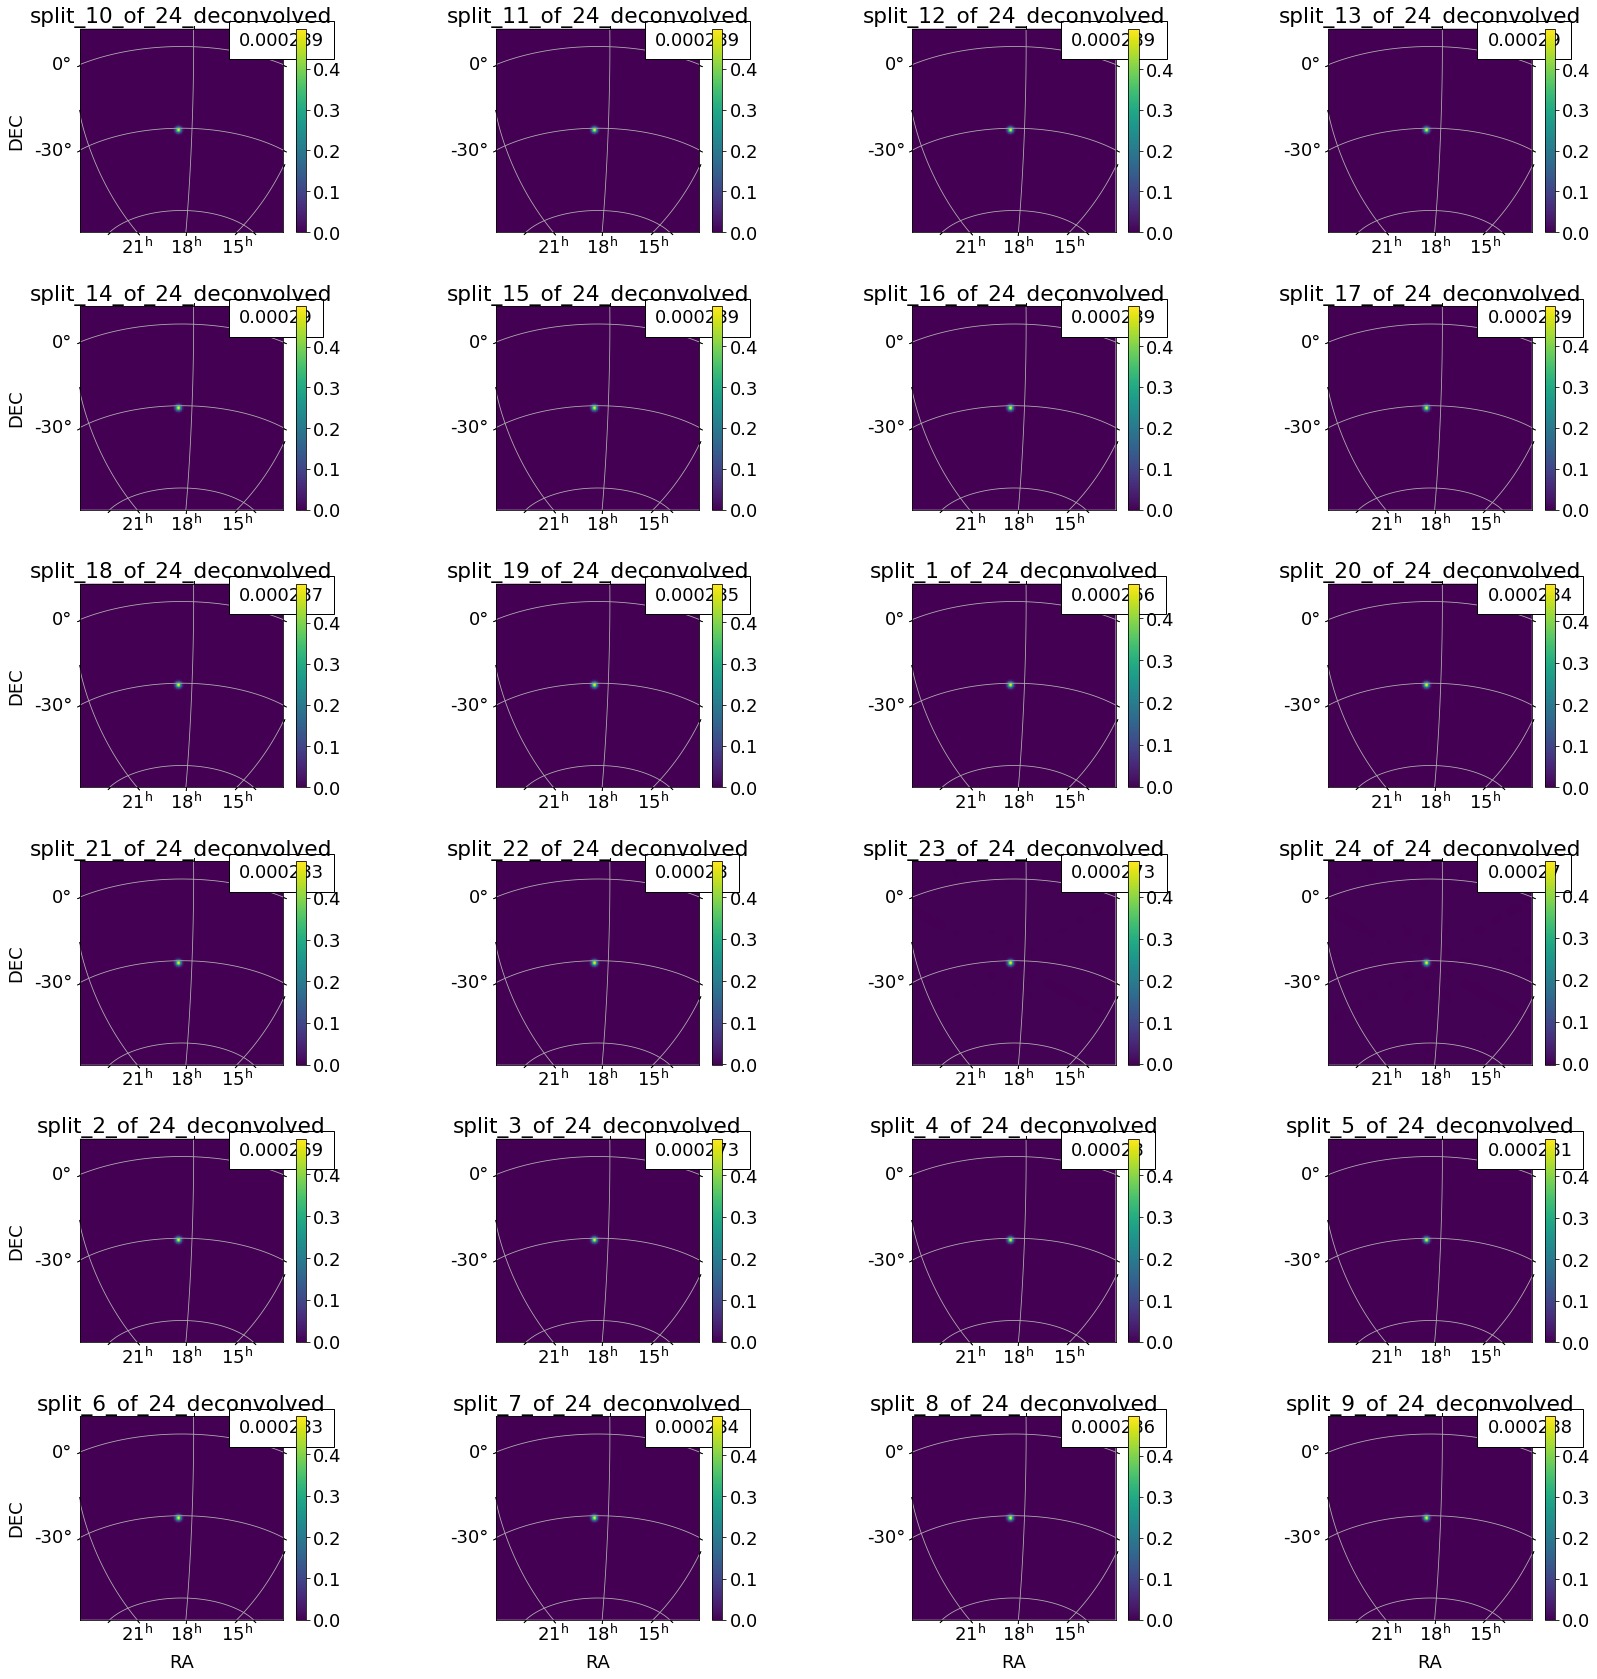

In [100]:
plot_all(fits_names=[image, residual], rows=6, titles=titles,
         combine = lambda d : d[0] - d[1], display_statistic=np.mean)

In [5]:
plot_all(fits_names=[model], rows=4, titles=titles, 
         combine = lambda d : d[0] / (d[0] >= 0), lim=[0,0.01],
         display_statistic = lambda d : np.sum(d != 0))

NameError: name 'model' is not defined

In [11]:
plot_all(sorted(glob.glob(path+"*mask.fits"))[0:2], rows=1, display_statistic=np.mean)

Exception: empty list given

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
(4, 1, 512, 512)
210.83627319335938


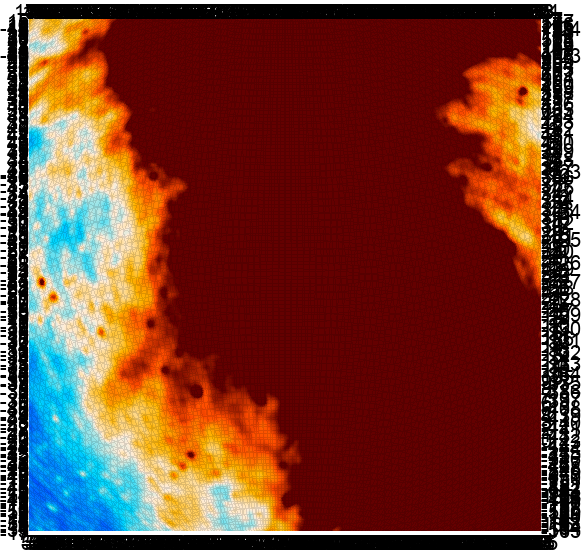

'Done!'

In [17]:
#from Gonzalo's GSM_modeling

import healpy as hp
from pixell import enmap
from pixell import reproject
from pixell import enplot
from astropy.wcs import WCS

# Convenient wrapper for displaying enmaps
def eshow(x,**kwargs): enplot.show(enplot.plot(x,**kwargs)) 

def GSM_from_fits(fitsfile,outfile,showplot=True):
    """This function will take a fitsfile, and create a GSM model of same area
    Arguments: 
    fitsfile: Path to fits file with shape (nx,ny,pol,freq
    outfile: Name of output GSM fits file
    Returns:
    GSM model over area of input fitsimage
    """
    #read in input fits image
    image = enmap.read_map(fitsfile)
    #read GSM model
    gsm_hp = hp.read_map('/lustre/aoc/projects/hera/gtucker/repositories/plimpy/PolarizedImaging/GSM150MHz.fits')
    #Project a healpix map to an enmap of chosen shape and wcs
    print(image.shape)
    gsm = reproject.enmap_from_healpix_interp(gsm_hp, image[0,0,:,:].shape, image.wcs)
    print(gsm.min())
    gsm -= gsm.min()
    #print(gsm)
    if showplot == True:
        eshow(gsm, min=-45, max = 300)
    else:
        pass
    enmap.write_fits(outfile+'.fits',gsm)
    return 'Done!'
#A test
GSM_from_fits(no_deconvolution[0], path+'GSM_test')

In [ ]:
path = "/lustre/aoc/projects/hera/aseidel/mask_and_none_simulated/"
plot_all([[path+'GSM_test.fits'],['muellerbeam.fits']], 
         combine=lambda d : d[0] * d[1])